# Aufgabe 44 Analyse von Temperaturdaten

In [1]:
# matplotlib Einstellungen
%config InlineBackend.figure_formats = ['svg','png']
import matplotlib as mpl
mpl.rcParams['font.size'] = 13
mpl.rcParams['figure.figsize'] = (7,5)
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## a) Daten inspizieren

In [3]:
df = pd.read_csv('Temperaturdaten_Dortmund.csv')
df

,Datum,Uhrzeit,Messzeit,Temperatur
0,01.01.2000,00:00,2000.000000,3.0
1,01.01.2000,00:15,2000.000028,3.0
2,01.01.2000,00:30,2000.000057,3.0
3,01.01.2000,00:45,2000.000085,3.0
4,01.01.2000,01:00,2000.000114,3.0
...,...,...,...,...
307885,31.12.2008,23:10,2008.999905,-4.0
307886,31.12.2008,23:20,2008.999924,-3.0
307887,31.12.2008,23:30,2008.999943,-3.0
307888,31.12.2008,23:40,2008.999962,-4.0


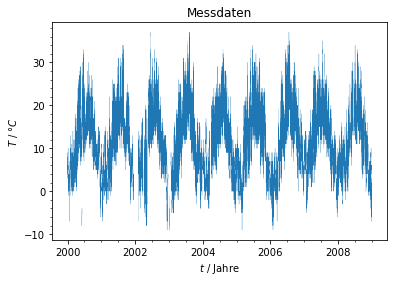

In [4]:
plt.title('Messdaten')
plt.plot(df['Messzeit'],df['Temperatur'], linewidth=0.2)
plt.xlabel('$t$ / Jahre')
plt.ylabel('$T$ / $°C$')
plt.show()

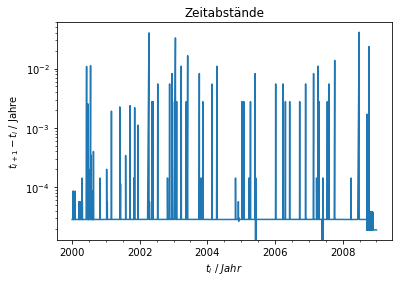

In [5]:
plt.title('Zeitabstände')
plt.plot(df['Messzeit'], df['Messzeit'].diff())
plt.xlabel('$t_i$ / $Jahr$')
plt.ylabel('$t_{i+1} - t_i$ / Jahre')
plt.yscale('log')
plt.show()

In [6]:
# Anzahl von Fehlenden Werten
df.isnull().sum()

Datum             0
Uhrzeit           0
Messzeit          0
Temperatur    20273
dtype: int64

Fouriertransformation (DFT oder FFT) ist hier nicht ohne Weiteres anwendbar, da die Zeitabstände nicht gleichmäßig sind.  
Gridding wäre möglich, aber ist nicht zu empfehlen, da dadurch die Analyse sehr ungenau wird.  
Ein Lomb-Scargle Periodogram ist anwendbar, wenn die NaN Werte entfernt werden.

## b) Daten für Lomb-Scargle Periodogram vorbereiten

In [7]:
df = df.dropna()

In [8]:
# Anzahl von Fehlenden Werten
df.isnull().sum()

Datum         0
Uhrzeit       0
Messzeit      0
Temperatur    0
dtype: int64

In [9]:
# Numpy Arrays statt Pandas DataFrame
temp = df['Temperatur'].to_numpy()
time = df['Messzeit'].to_numpy()

In [10]:
# Verschiebe die Temperatur sodass die Schwingung um 0 ist.
temp_mean = np.mean(df['Temperatur'])
temp_offset = temp - temp_mean

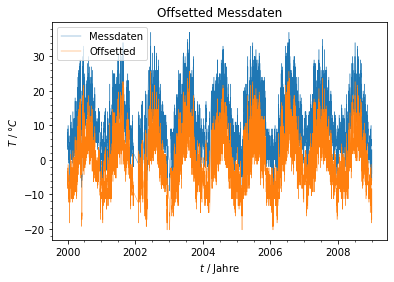

In [11]:
plt.title('Offsetted Messdaten')
plt.plot(time, temp, label='Messdaten', linewidth=0.4)
plt.plot(time, temp_offset, label='Offsetted', linewidth=0.4)
plt.xlabel('$t$ / Jahre')
plt.ylabel('$T$ / $°C$')
plt.legend()
plt.show()

## c) Analyse mit Lomb-Scargle Periodogramm

### Welche Frequenzen können minimal und maximal aufgelöst werden?

Wenn $\Delta t$ die Zeitdifferenz vom Anfang zum Ende ist und $\delta t$ der Zeitabstand von zwei Messwerten ist, dann:  
Maximale auflösbare Frequenz: $f_{max} = \frac{1}{2\delta t}$  
Minimale auflösbare Frequenz: $f_{min} = \frac{1}{\Delta t}$  

Bzw.:  
Minimale auflösbare Periodendauer: $T_{min} = 2 \delta t$ (Periodizität bei jedem 2ten Messwert)  
Maximale auflösbare Periodendauer: $T_{max} = \Delta t$ (1 Periode im gesammten Messzeitraum)  

### Welche Periodizität ist zu erwarten?

Aus Vorwissen sind die zu erwartende Periodizitäten in der Temperatur jährlich und täglich also:  
$f_1 = \frac{1}{\text{Jahr}}$ und $f_2 = \frac{1}{\text{Tag}}$

### Analyse mit Lomb-Scargle Periodogramm

In [12]:
from scipy.signal import lombscargle

def plot_lombscargle(f_min, f_max, time, temp, n_freq=1000, title='', log=False):
    if log: freq = np.geomspace(f_min, f_max, n_freq)
    else: freq = np.linspace(f_min, f_max, n_freq)
    ang_freq = freq*2*np.pi
    
    pgram = lombscargle(time, temp, ang_freq)
    
    plt.title(title)
    plt.plot(freq, pgram)
    plt.xlabel('$f$ / Jahre$^{-1}$')
    plt.ylabel('$P(f)$')
    if log: plt.xscale('log')
    plt.show()

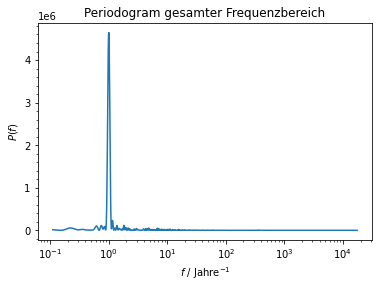

In [13]:
mins_per_year = 365 * 24 * 60
delta_t = 15 / mins_per_year
Delta_t = time[-1] - time[0]

f_min = 1/Delta_t
f_max = 1/(2*delta_t)

plot_lombscargle(f_min, f_max, time, temp_offset, title='Periodogram gesamter Frequenzbereich', log=True)

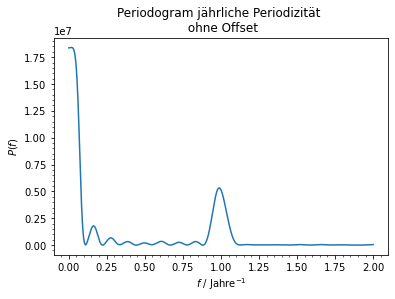

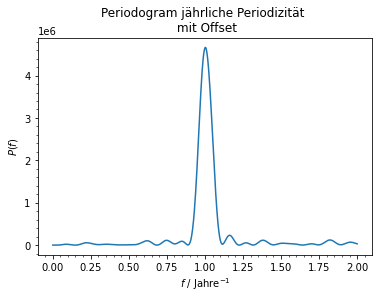

In [14]:
plot_lombscargle(0.001, 2, time, temp, title='Periodogram jährliche Periodizität \n ohne Offset')
plot_lombscargle(0.001, 2, time, temp_offset, title='Periodogram jährliche Periodizität \n mit Offset')

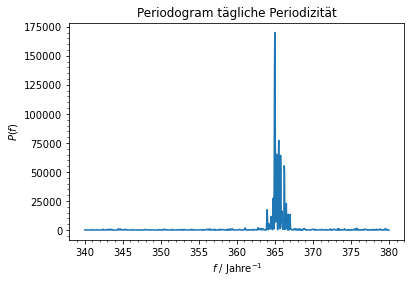

In [15]:
plot_lombscargle(340, 380, time, temp_offset, title='Periodogram tägliche Periodizität')

Es lassen sich zwei Peaks bei den zu erwartenden Frequenzen erkennen.

## d) Fouriertransformation

### Gridding

In [16]:
# Gridding Abstand in Jahren
delta_time = 15 # min
delta_time = delta_time / mins_per_year # Jahre
print(f'Minuten pro Jahr: {mins_per_year}')
print(f'Zeitabstand: 15 min = {delta_time:.7f} Jahre')

Minuten pro Jahr: 525600
Zeitabstand: 15 min = 0.0000285 Jahre


In [17]:
from scipy.interpolate import interp1d

time_gridded = np.arange(np.min(time), np.max(time), delta_time)

temp_gridded = interp1d(time, temp_offset)(time_gridded)

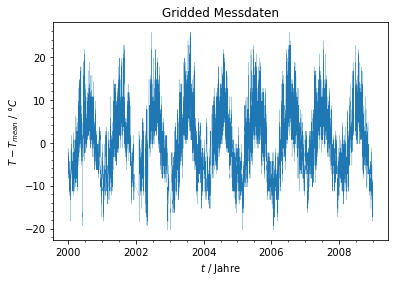

In [18]:
plt.title('Gridded Messdaten')
plt.plot(time_gridded,temp_gridded, linewidth=0.2)
plt.xlabel('$t$ / Jahre')
plt.ylabel('$T - T_{mean}$ / $°C$')
plt.show()

### Fast Fouriertransformation

In [19]:
from scipy.fft import rfft, rfftfreq

A_gridded = rfft(temp_gridded)
freq_gridded = rfftfreq(n = len(time_gridded), d = delta_time)

print('A und freq der rfft:')
A_gridded,freq_gridded

A und freq der rfft:


(array([-8.08460863e+04+0.00000000e+00j, -8.76927432e+03+1.14771652e+05j,
        -4.94437332e+04+5.17940876e+04j, ...,
         5.57732077e+00-3.50321787e+00j, -6.98631257e+01+1.66226049e+02j,
         1.42153641e+01+0.00000000e+00j]),
 array([0.00000000e+00, 1.11111111e-01, 2.22222222e-01, ...,
        1.75197778e+04, 1.75198889e+04, 1.75200000e+04]))

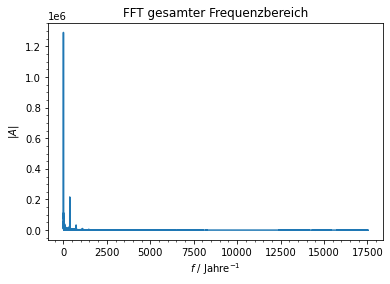

In [20]:
plt.title('FFT gesamter Frequenzbereich')
plt.plot(freq_gridded, np.abs(A_gridded))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.show()

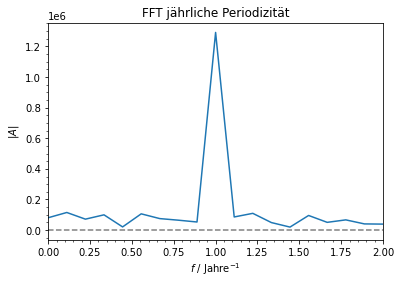

In [21]:
plt.title('FFT jährliche Periodizität')
plt.axhline(0, color='k', alpha=0.5, linestyle='--')
plt.plot(freq_gridded, np.abs(A_gridded))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.xlim(0,2)
plt.show()

In [22]:
phase_1 = np.rad2deg(np.angle(A_gridded[freq_gridded == 1.0]))[0]
print(f'Phase bei f=1/Jahr: {phase_1}')

Phase bei f=1/Jahr: 161.43297603615653


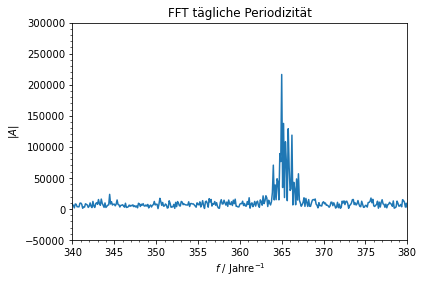

In [23]:
plt.title('FFT tägliche Periodizität')
plt.plot(freq_gridded, np.abs(A_gridded))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.xlim(340,380)
plt.ylim(-0.05*10**6, 0.3*10**6)
plt.show()

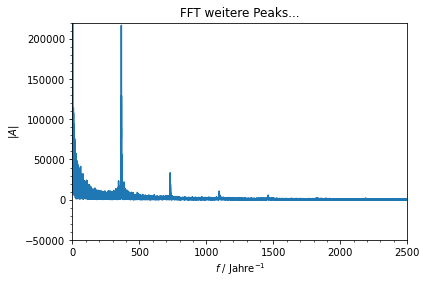

In [24]:
plt.title('FFT weitere Peaks...')
plt.plot(freq_gridded, np.abs(A_gridded))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.xlim(0,2500)
plt.ylim(-0.05*10**6, 0.22*10**6)
plt.show()

Auch bei der FFT lassen sich die zu erwartenden Peaks erkennen.  
Außerdem sind Peaks zu erkennen bei ungefähr ganzzahligen Vielfachen von 365...

### Just for Fun: Glättung / Fit durch inverse Fouriertransformation

In [25]:
# Entferne Frequenzen unter einem willkürlich gewählten threshold
A_threshold = 10**5
A_smoothed = np.copy(A_gridded)
A_smoothed[np.abs(A_gridded) < A_threshold] = 0

from scipy.fft import irfft

temp_smoothed = irfft(A_smoothed)

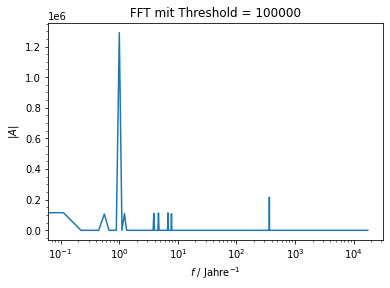

In [26]:
plt.title(f'FFT mit Threshold = {A_threshold}')
plt.plot(freq_gridded, np.abs(A_smoothed))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.xscale('log')
plt.show()

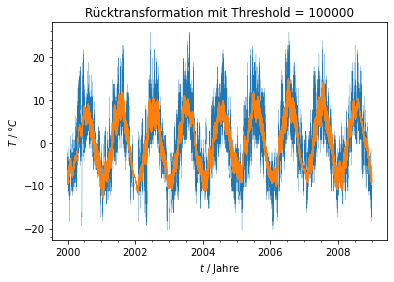

In [27]:
plt.title(f'Rücktransformation mit Threshold = {A_threshold}')
plt.plot(time_gridded,temp_gridded, linewidth=0.2)
plt.plot(time_gridded,temp_smoothed, linewidth=0.5)
plt.xlabel('$t$ / Jahre')
plt.ylabel('$T$ / $°C$')
plt.show()

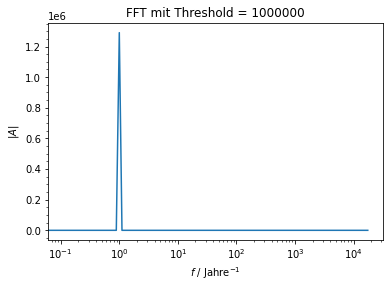

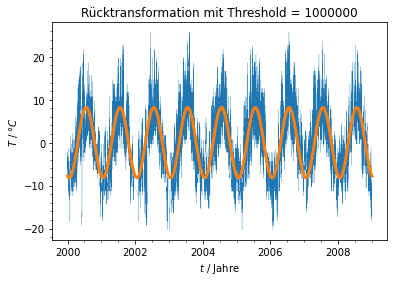

In [28]:
# nochmal mit nur der jährlichen Frequenz
A_threshold = 10**6
A_smoothed = np.copy(A_gridded)
A_smoothed[np.abs(A_gridded) < A_threshold] = 0

from scipy.fft import irfft

temp_smoothed = irfft(A_smoothed)

plt.title(f'FFT mit Threshold = {A_threshold}')
plt.plot(freq_gridded, np.abs(A_smoothed))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.xscale('log')
plt.show()

plt.title(f'Rücktransformation mit Threshold = {A_threshold}')
plt.plot(time_gridded,temp_gridded, linewidth=0.2)
plt.plot(time_gridded,temp_smoothed, linewidth=3)
plt.xlabel('$t$ / Jahre')
plt.ylabel('$T$ / $°C$')
plt.show()

# Aufgabe 45: Kurzfragen zur harmonischen Analyse

## Welche Frequenzen erlaubt das Nyquist-Shannon Abtasttheorem

Wenn eine Funktion $x(t)$ $N$ mal in Abständen $\Delta t$ abgetastet (sampled) wurde, können nur Frequenzen $f < \frac{1}{2\Delta t}$ in den abgetasteten Werten enthalten sein.  

Bei der diskreten Fouriertransformation können somit die Kreisfrequenzen $\omega \in [-\frac{\pi}{\Delta t}, \frac{\pi}{\Delta t}]$ in Abständen $\Delta \omega = \frac{2 \pi}{N \Delta t}$ analysiert werden.  
Also $\omega_n = \frac{2 \pi}{N \Delta t} n$.

## Warum kann Gridding notwendig sein, welches Problem kann auftreten?

Die diskrete Fouriertransformation kann nur verwendet werden, wenn die Messdaten gleichmäßige (Zeit-)Abstände aufweisen.
Gridding erzeugt gleichmäßig verteilte Werte aus ungleichmäßig verteilten Messwerten.

Durch Gridding werden die Messdaten verändert und es werden Frequenzen in die Daten einfließen, die eigentlich in den Messdaten nicht enthalten sind.  
Das führt meistens dazu, dass die Fouriertransformation keine klaren Peaks mehr besitzen, sondern dass die Frequenzen "ausgeschmiert" werden.

## Umreißen Sie kurz die Idee hinter der Fast Fouriertransformation

Die in der DFT auftretende Summe benötigt $O(N^2)$ Operationen um berechnet zu werden.  
Man kann ausnutzen, dass die Fouriertransformation in zwei DFT mit halber Anzahl an Messwerten aufgeteilt werden kann.  
Diese zwei DFTs benötigen allerdings nur ein viertel so viele Operationen wie die ganze DFT.  
Wenn man so die DFTs immer in kleinere DFTs aufteilt kommt man zu einer Laufzeit von $O(N \log N)$ was wesentlich schneller ist als $O(N^2)$.  
FFT ist also ein "divide and conquer" Algorithmus.

Vorraussetzung ist, dass die Anzahl der Messpunkte $N = 2^m$ mit $m \in \mathbb{N}$ ist.

## Wie unterscheiden sich Fourier-Transformation und Lomb-Scargle Periodogramm?

Die DFT liefert für fest bestimmte Frequenzen die komplexe Amplitude der Fourierreihe, also sowohl Amplitude als auch Phase.  

Das Lomb-Scargle Periodogramm liefert für beliebige Frequenzen das geschätzte Betragsquadrat der Amplitude.  
Allerdings so als würde ein Least-Squares-Fit mit einer Summe von Sinusfunktionen durchgeführt werden.  
Also werden hier keine Phasen bestimmt.

## Was sind die Vorteile der Fourier-Transformation oder der Lomb-Scargle Periodogramme?  

Vorteile DFT:  
- gibt auch Phasen zurück  
- sehr effizient  
- kann invertiert werden  

Vorteile Lomb-Scargle Periodogramm:  
- benötigt nicht (zeitlich) gleichmäßig verteilte Messdaten  
- höhere Frequenzauflösung, bzw. beliebige Frequenzen können analysiert werden  
- ideal für den Nachweis einer Frequenzkomponente (was soll das bedeuten?)  